Sets `CUDA_VISIBLE_DEVICES` to '3' to select a specific GPU for JAX and TensorFlow.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
print(f"CUDA_VISIBLE_DEVICES set to: {os.environ['CUDA_VISIBLE_DEVICES']}")

CUDA_VISIBLE_DEVICES set to: 1


In [2]:
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.9'  # 30% GPU memory

Imports all essential Python libraries for numerical computation, JAX, TensorFlow, Haiku, plotting, and utility functions.

In [3]:
import argparse
import pickle
from functools import partial

import haiku as hk
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import optax
import tensorflow as tf
import tensorflow_probability as tfp
from chainconsumer import ChainConsumer
from haiku._src.nets.resnet import ResNet18
from jax.lib import xla_bridge
from numpyro import distributions as dist
from numpyro.handlers import condition, seed, trace
from tqdm import tqdm
import numpy as np
import h5py
import healpy as hp 
import jax
import matplotlib.pyplot as plt

print("Platform =",xla_bridge.get_backend().platform)

2025-08-11 12:31:28.360372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754915488.375253 1964717 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754915488.379963 1964717 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_1964717/3513268445.py:27: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print("Platform =",xla_bridge.get_backend().platform)


Platform = gpu


Imports specific normalizing flow model components (`AffineCoupling`, `ConditionalRealNVP`, `TrainModel`) from the `sbi_lens` library.

In [4]:
from sbi_lens.normflow.models import AffineCoupling, ConditionalRealNVP
from sbi_lens.normflow.train_model import TrainModel

Configures TensorFlow to use JAX backend, enables memory growth for GPUs, and prints CPU/GPU memory usage and available GPUs.

In [5]:
# tfp = tfp.experimental.substrates.jax
from tensorflow_probability.substrates import jax as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Memory growth set for visible GPUs: {gpus}")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import psutil
# Get CPU memory usage
cpu_memory_usage = psutil.virtual_memory().percent
print("CPU Memory Usage:", cpu_memory_usage, "%")

import GPUtil
# Get available GPUs
gpus_gputil = GPUtil.getGPUs()
for gpu in gpus_gputil:
    if str(gpu.id) == '0': # Check if this is the desired GPU
        memory_usage_percentage = (gpu.memoryUsed / gpu.memoryTotal) * 100
        print(f"GPU ID: {gpu.id}, GPU Name: {gpu.name}, GPU Memory Usage: {memory_usage_percentage:.2f}%")

Memory growth set for visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CPU Memory Usage: 21.9 %
GPU ID: 0, GPU Name: NVIDIA A100-SXM4-40GB, GPU Memory Usage: 0.01%


Defines global string variables `map_kind` and `loss_name` to configure the type of maps and loss function used in the analysis.

In [6]:
map_kind = 'nbody' # nbody or nbody_with_baryon_ia or gaussian
loss_name = 'vmim'

Markdown: Section title for 'Fiducial Model'.

### Fiducial Model

Defines simulation settings (e.g., map size, resolution), loads fiducial cosmological parameters, and generates a noisy observed map data.

In [7]:
print("######## CONFIG ########")

sigma_e = 0.26
galaxy_density = 30 / 4
field_size = size = 10
field_npix = xsize = 80
nside = 512
reso = size * 60 / xsize
nbins = 4
param_dim = 6
output_dim = 12

print("######## OBSERVED DATA ########")
filename = '/home/tersenov/CosmoGridV1/CosmoGridV1_metainfo.h5'
f = h5py.File(filename, "r")
dataset_grid = f['parameters']['fiducial']
cosmo_parameters = jnp.array([
            dataset_grid['Om'],
            dataset_grid['s8'],
            dataset_grid['w0'],
            dataset_grid['H0']/100,
            dataset_grid['ns'],
            dataset_grid['Ob']
        ]).T
truth = list(cosmo_parameters[0])
print('TRUTH=', truth)
path = '/home/tersenov/CosmoGridV1/stage3_forecast/fiducial/cosmo_fiducial/perm_0004/projected_probes_maps_nobaryons512.h5'
# path = '/home/tersenov/CosmoGridV1/stage3_forecast/fiducial/cosmo_fiducial/perm_0000/projected_probes_maps_baryonified512.h5'

m_data_h5 = h5py.File(path, "r")
# Build 4-channel tomographic observed map (bins 1..4), then project each with same projector
proj = hp.projector.GnomonicProj(rot=[0, 0, 0], xsize=xsize, ysize=xsize, reso=reso)
proj_bins = []
for b in (1, 2, 3, 4):
    full_map = np.array(m_data_h5["kg"][f"stage3_lensing{b}"])
    proj_map = proj.projmap(full_map, vec2pix_func=partial(hp.vec2pix, nside))
    proj_bins.append(proj_map)
# Stack into (H, W, 4)
m_data = np.stack(proj_bins, axis=-1).astype(np.float32)
# Add shape noise equally to each bin
stddev = sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2)
m_data = jnp.asarray(m_data) + jax.random.normal(jax.random.PRNGKey(0), (field_npix, field_npix, nbins)) * stddev

######## CONFIG ########
######## OBSERVED DATA ########
TRUTH= [Array(0.26, dtype=float32), Array(0.84, dtype=float32), Array(-1., dtype=float32), Array(0.6736, dtype=float32), Array(0.9649, dtype=float32), Array(0.0493, dtype=float32)]


Displays the generated noisy observed map using `matplotlib.pyplot.imshow`.

In [8]:
m_data.shape

(80, 80, 4)

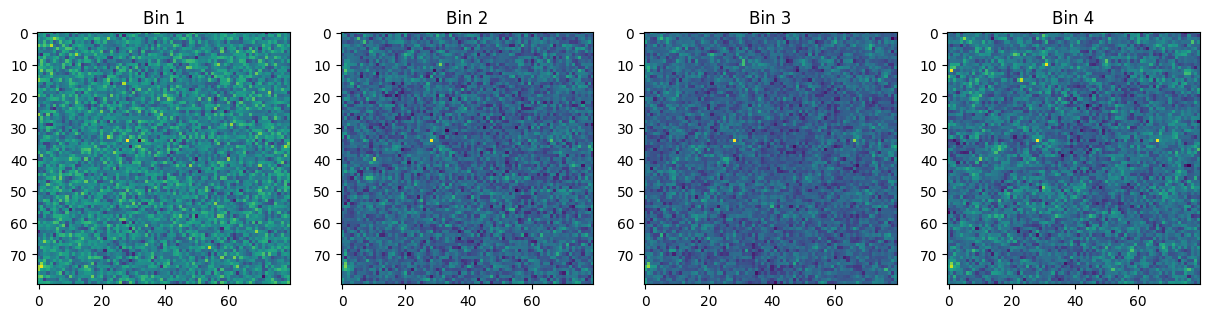

In [9]:
# plot in subplots all the 4 bins m_data[:,:,i]
plt.figure(figsize=(15, 10))
for i in range(nbins):
    plt.subplot(1, 4, i + 1)
    plt.imshow(m_data[:, :, i].squeeze())
    plt.title(f'Bin {i + 1}')
    

Markdown: Section title for 'Compressing Data'.

### Compressing Data

Defines a Haiku module `CompressorCNN2D`, a Convolutional Neural Network, to compress input 2D maps to a lower-dimensional representation.

In [10]:
print("######## CREATE COMPRESSOR ########")

# compressor
class CompressorCNN2D(hk.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.output_dim = output_dim

    def __call__(self, x):
        net_x = hk.Conv2D(32, 3, 2)(x) 
        net_x = jax.nn.leaky_relu(net_x)
        net_x = hk.Conv2D(64, 3, 2)(net_x) 
        net_x = jax.nn.leaky_relu(net_x)
        net_x = hk.Conv2D(128, 3, 2)(net_x)
        net_x = jax.nn.leaky_relu(net_x)
        net_x = hk.AvgPool(16,8,'SAME')(net_x) 
        net_x = hk.Flatten()(net_x)

        net_x = hk.Linear(64)(net_x)
        net_x = jax.nn.leaky_relu(net_x)
        net_x = hk.Linear(self.output_dim)(net_x)
        
        return net_x.squeeze()
    
compressor = hk.transform_with_state(lambda y: CompressorCNN2D(output_dim)(y))

######## CREATE COMPRESSOR ########


Prints the Haiku transformed `compressor` object, showing its structure.

In [11]:
compressor

TransformedWithState(init=<function transform_with_state.<locals>.init_fn at 0x7b741c3f7b00>, apply=<function transform_with_state.<locals>.apply_fn at 0x7b741c3f7a60>)

Loads pre-trained parameters for the `CompressorCNN2D` and its optimizer state from specified pickle files.

In [11]:
# load compressor parameters and optimizer state from file 
path = f"/home/tersenov/software/cnn_sbi/scripts/sbi/save_params/{loss_name}/{map_kind}/gal_density_30/params_nd_compressor_batch150000.pkl"
with open(path, "rb") as g:
    parameters_compressor = pickle.load(g)
    
path = f"/home/tersenov/software/cnn_sbi/scripts/sbi/save_params/{loss_name}/{map_kind}/gal_density_30/opt_state_resnet_batch150000.pkl"
with open(path, "rb") as g:
    opt_state_resnet = pickle.load(g)

In [12]:
# load compressor parameters and optimizer state from file 
path = f"/home/tersenov/software/cnn_sbi/tomo/save_params/vmim/nbody/12features/sigma_0.26/gal_density_30/bin_4/params_nd_compressor_batch150000_12features.pkl"
with open(path, "rb") as g:
    parameters_compressor = pickle.load(g)

path = f"/home/tersenov/software/cnn_sbi/tomo/save_params/vmim/nbody/12features/sigma_0.26/gal_density_30/bin_4/opt_state_resnet_batch150000_12features.pkl"
with open(path, "rb") as g:
    opt_state_resnet = pickle.load(g)

Defines data augmentation functions: `augmentation_noise` (adds noise based on `map_kind`), `augmentation_flip` (random flips), `rescale_h` (rescales H0), and a combined `augmentation` function.

In [13]:
print("######## DATA AUGMENTATION ########")
tf.random.set_seed(1)

if map_kind =='nbody_with_baryon_ia':
    print('nbody w baryon and ia')
    def augmentation_noise(
        example, sigma_e=0.26, galaxy_density=27, field_size=5, field_npix=256
    ):
        x = example["map_nbody_w_baryon_ia"]
        x += tf.random.normal(
            shape=(field_npix, field_npix, nbins),
            stddev=sigma_e
            / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
        )

        return {"maps": x, "theta": example["theta"]}


elif map_kind =='nbody':
    print('nbody')
    def augmentation_noise(
        example, sigma_e=0.26, galaxy_density=27, field_size=5, field_npix=256
    ):
        x = example["map_nbody"]
        x += tf.random.normal(
            shape=(field_npix, field_npix, nbins),
            stddev=sigma_e
            / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
        )

        return {"maps": x, "theta": example["theta"]}
    
elif map_kind=='gaussian':
    print('gaussian')
    def augmentation_noise(
        example, sigma_e=0.26, galaxy_density=27, field_size=5, field_npix=256
    ):
        x = example["map_gaussian"]
        x += tf.random.normal(
            shape=(field_npix, field_npix, nbins),
            stddev=sigma_e
            / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
        )

        return {"maps": x, "theta": example["theta"]}
    

def augmentation_flip(example):
    x = example["maps"]
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return {"maps": x, "theta": example["theta"]}

def rescale_h(example): 
    x = example['theta']
    index_to_update = 3
    x = tf.tensor_scatter_nd_update(x, [[index_to_update]], [x[index_to_update] / 100])
    return {"maps": example["maps"], "theta": x}

def augmentation(example):
    return rescale_h(
        augmentation_flip(
            augmentation_noise(
                example=example,
                sigma_e=sigma_e,
                galaxy_density=galaxy_density,
                field_size=field_size,
                field_npix=field_npix,
            )
        )
    )

######## DATA AUGMENTATION ########
nbody


Loads dataset using `tfds` (e.g., 'NbodyCosmogridDataset'), applies augmentations, compresses test/train maps and the observed map using the pre-trained compressor.

In [14]:
import tensorflow_datasets as tfds
import numpy
print("######## COMPRESS DATA ########")
ds = tfds.load(
    # 'CosmogridGridDataset/grid',
    'NbodyCosmogridDatasetTomo/grid',
    split='test'
)
ds = ds.map(augmentation)
ds = ds.batch(500)

iter = ds.as_numpy_iterator()

y = []
theta = []
score = []

for example in iter:
  comp_y,_ = compressor.apply(
      parameters_compressor,
      opt_state_resnet,
      None,
      example['maps']
    )
  y.append(comp_y)
  theta.append(example['theta'])

dataset = {
    'theta': np.concatenate(theta, axis=0), 
    'x': np.concatenate(y, axis=0), 
}
compressed_dataset_test, _ = compressor.apply(
      parameters_compressor,
      opt_state_resnet,
      None,
      example['maps']
    )
theta_test =example['theta']

####################################
ds = tfds.load(
    # 'CosmogridGridDataset/grid',
    'NbodyCosmogridDatasetTomo/grid',
    split='train'
)
ds = ds.map(augmentation)
ds = ds.batch(500)

iter = ds.as_numpy_iterator()

y = []
theta = []
score = []

for example in iter:
  comp_y,_ = compressor.apply(
      parameters_compressor,
      opt_state_resnet,
      None,
      example['maps']
    )
  y.append(comp_y)
  theta.append(example['theta'])

dataset_test = {
    'theta': np.concatenate(theta, axis=0), 
    'x': np.concatenate(y, axis=0), 
}

compressed_dataset_train, _ = compressor.apply(
      parameters_compressor,
      opt_state_resnet,
      None,
      example['maps']
    )
theta_train =example['theta']

###########################################
compressed_m_data, _ = compressor.apply(
      parameters_compressor,
      opt_state_resnet,
      None,
      m_data.reshape([1,field_npix,field_npix,nbins])
    )

######## COMPRESS DATA ########
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: `haiku.experimental.flax` features require `flax` to be installed.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1754915562.254588 1964717 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 807 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: `haiku.experimental.flax` features require `flax` to be installed.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: `haiku.experimental.flax` features require `flax` to be installed.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Generates scatter plots comparing true cosmological parameters against their compressed (predicted) values for test and train datasets to evaluate compressor performance.

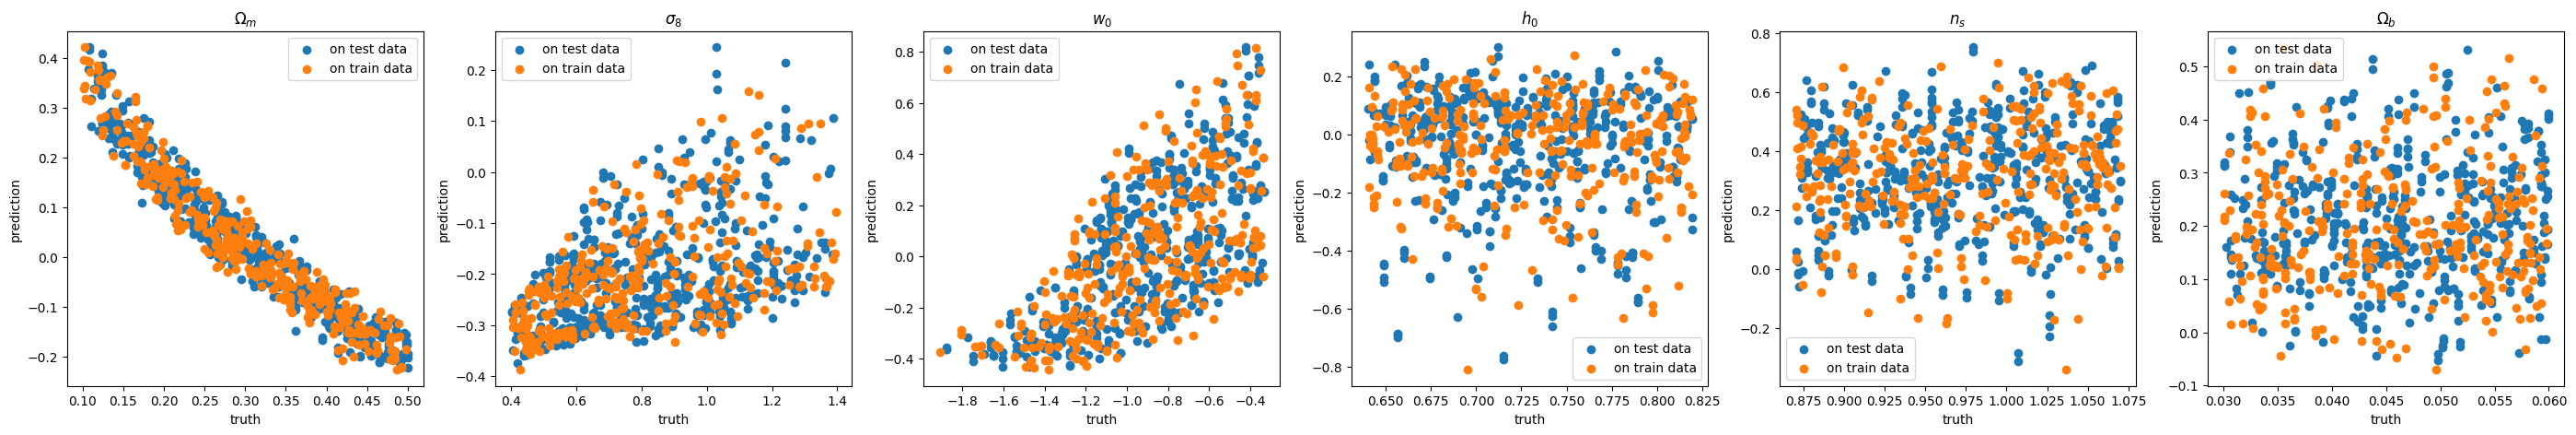

In [15]:
params_name = [r'$\Omega_m$',r'$\sigma_8$',r'$w_0$',r'$h_0$',r'$n_s$', r'$\Omega_b$']
plt.figure(figsize=(35,5))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.scatter(theta_test[:,i], compressed_dataset_test[:,i], label = 'on test data')
    plt.scatter(theta_train[:,i], compressed_dataset_train[:,i], label = 'on train data')
    plt.xlabel('truth')
    plt.ylabel('prediction')
    plt.title(params_name[i])
    plt.legend()

Markdown: Section title for 'Inference'.

## Inference

### NLE

Defines the Neural Density Estimator (NDE) architecture using a `ConditionalRealNVP` (normalizing flow) model from `sbi_lens` via Haiku, to approximate `p(theta | y)`.

In [16]:
print("######## CREATE NDE ########")
# Create neural density estimator (NDE) to approximate p(theta | y)

summary_stat_dim = 12
nb_params_to_infer = 6
batch_size = 128


# Affine bijection used in the RealNVP coupling
bijector_ff = partial(
  AffineCoupling,
  layers=[128] * 4,
  activation=jax.nn.silu
)

# Normalizing Flow with 4 RealNVP coupling layers
NF_ff = partial(
  ConditionalRealNVP,
  n_layers=4,
  bijector_fn=bijector_ff
)

class NF(hk.Module):
    def __call__(self, y):
        nvp = NF_ff(nb_params_to_infer)(y)
        return nvp

# log probability of the NDE
nf_logp_ff = hk.without_apply_rng(
    hk.transform(
        lambda theta,y : NF()(theta).log_prob(y).squeeze()
    )
)

######## CREATE NDE ########


Defines utility functions for NDE training: `loss_nll` (negative log-likelihood loss) and a JIT-compiled `update` step for optimization.

In [17]:
print("######## UTILS FUN ########")

# negative log likelihood
def loss_nll(params, mu, batch):
    return - jnp.mean(nf_logp_ff.apply(params, mu, batch))

@jax.jit
def update(params, opt_state, mu, batch):
    """Single SGD update step."""
    loss, grads  = jax.value_and_grad(loss_nll)(
        params,
        mu,
        batch,
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

######## UTILS FUN ########


Trains the NDE (normalizing flow) using the Adam optimizer with an exponential decay learning rate. Saves model parameters periodically and plots batch loss.

######## TRAINING ########


loss -19.361: 100%|██████████| 50000/50000 [02:14<00:00, 372.00it/s]


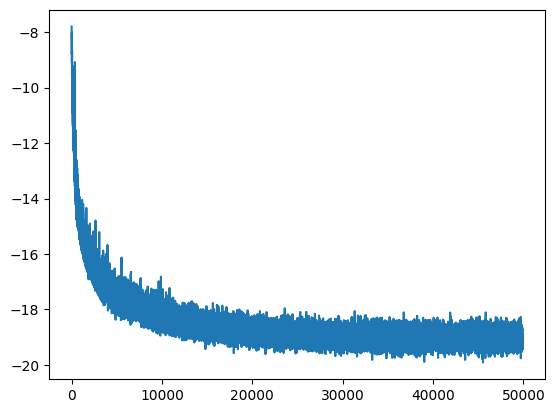

In [18]:
print("######## TRAINING ########")
# init nf params
params_ff = nf_logp_ff.init(
    jax.random.PRNGKey(42),
    0.5 * jnp.zeros([1, 6]),
    0.5 * jnp.zeros([1, 6])
)

total_steps = 50_000
nb_steps = total_steps - total_steps * 0.2

lr_scheduler = optax.exponential_decay(
        init_value=1e-3,
        transition_steps=nb_steps // 50,
        decay_rate=0.9,
        end_value=1e-6,
)

# define optimizer
optimizer = optax.adam(learning_rate=lr_scheduler)
opt_state_ff = optimizer.init(params_ff)


# training
from tqdm import tqdm

batch_size = 128
batch_loss = []
loss_train = []
loss_test=[]
pbar = tqdm(range(total_steps))

for batch in pbar:
    inds = np.random.randint(0, len(dataset['theta']), batch_size)

    l, params_ff, opt_state_ff = update(
      params_ff,
      opt_state_ff,
      dataset['theta'][inds],
      dataset['x'][inds],
    )
    batch_loss.append(l)
    pbar.set_description(f"loss {l:.3f}")
    
    
    if batch % 1_000 == 0:

        # save params
        with open(f"/home/tersenov/software/Learn2Map/scripts/sbi/save_params/{loss_name}/nbody/params_nd_flow_batch{batch}.pkl", "wb") as fp:
            pickle.dump(params_ff, fp)


        inds2 = np.random.randint(0, len(dataset_test["theta"]), batch_size)
        b_loss_test, _, _ = update(
          params_ff,
          opt_state_ff,
          dataset_test["theta"][inds2],
          dataset_test['x'][inds2],
        )
        

        loss_train.append(l)
        loss_test.append(b_loss_test)


plt.plot(batch_loss[100:])

Plots the training and validation (test set) loss curves over training epochs for the NDE.

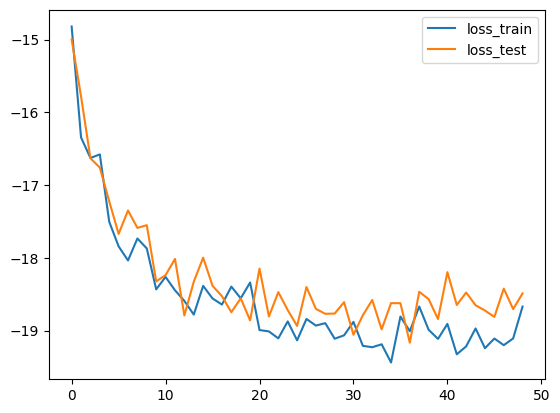

In [19]:
plt.plot(loss_train[1:], label ='loss_train')
plt.plot(loss_test[1:], label = 'loss_test')
plt.legend()

Defines a list of LaTeX parameter names (`params_name`) and creates a dictionary `theta` mapping these names to their true fiducial cosmological values.

In [20]:
params_name = [r'$\Omega_m$',r'$\sigma_8$',r'$w_0$',r'$h_0$',r'$n_s$', r'$\Omega_b$']
# make dictionary or {'name': value as float}
truth_arr = np.array(truth)
theta = dict(zip(params_name, truth_arr))

Samples from the trained NDE (likelihood) and visualizes the resulting distributions using `ChainConsumer`. Note: Conditioning in this cell might be for debugging/exploration.

In [21]:
theta

{'$\\Omega_m$': 0.26,
 '$\\sigma_8$': 0.84,
 '$w_0$': -1.0,
 '$h_0$': 0.6736,
 '$n_s$': 0.9649,
 '$\\Omega_b$': 0.0493}

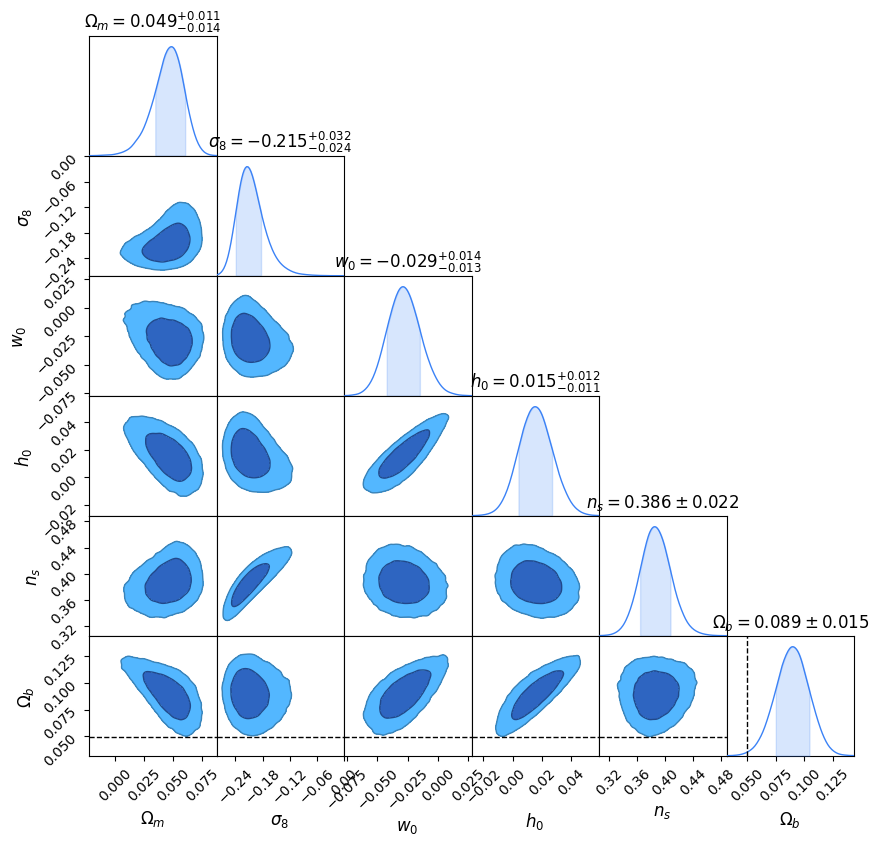

In [22]:
# just checking the learned likelihood

nvp_sample_nd = hk.transform(
  lambda y : NF()(y).sample(100000, seed=hk.next_rng_key())
)

# plot infered params
sample_nd = nvp_sample_nd.apply(
      params_ff,
      rng = jax.random.PRNGKey(43),
      y = jnp.array(truth) * jnp.ones([100_000, 6])
)

params_name = [r'$\Omega_m$',r'$\sigma_8$',r'$w_0$',r'$h_0$',r'$n_s$', r'$\Omega_b$']
c = ChainConsumer()

import pandas as pd
from chainconsumer import Chain, ChainConsumer, Truth

df = pd.DataFrame(sample_nd, columns=params_name)  # Convert to DataFrame
chain = Chain(samples=df, name="SBI")  # Pass the DataFrame instead of NumPy array
c.add_chain(chain)
c.add_truth(Truth(location=theta))
# c.add_chain(
#     sample_nd,
#     shade_alpha = 0.5, 
#     parameters = params_name, 
#     name = f'sbi with {map_kind} maps'
# )

fig = c.plotter.plot(figsize=0.5)

Prints the individual true fiducial cosmological parameter values stored in `truth_arr`.

In [23]:
for i, param in enumerate(params_name):
    # g.add_x_marker(truth_arr[i], color="red", linestyle="dashed")  # Vertical lines for truth
    print(truth_arr[i])

0.26
0.84
-1.0
0.6736
0.9649
0.0493


Generates a triangle plot of the samples obtained from the NDE using `getdist`, with true parameter values marked.

In [24]:
truth_arr

array([ 0.26  ,  0.84  , -1.    ,  0.6736,  0.9649,  0.0493],
      dtype=float32)

Removed no burn in


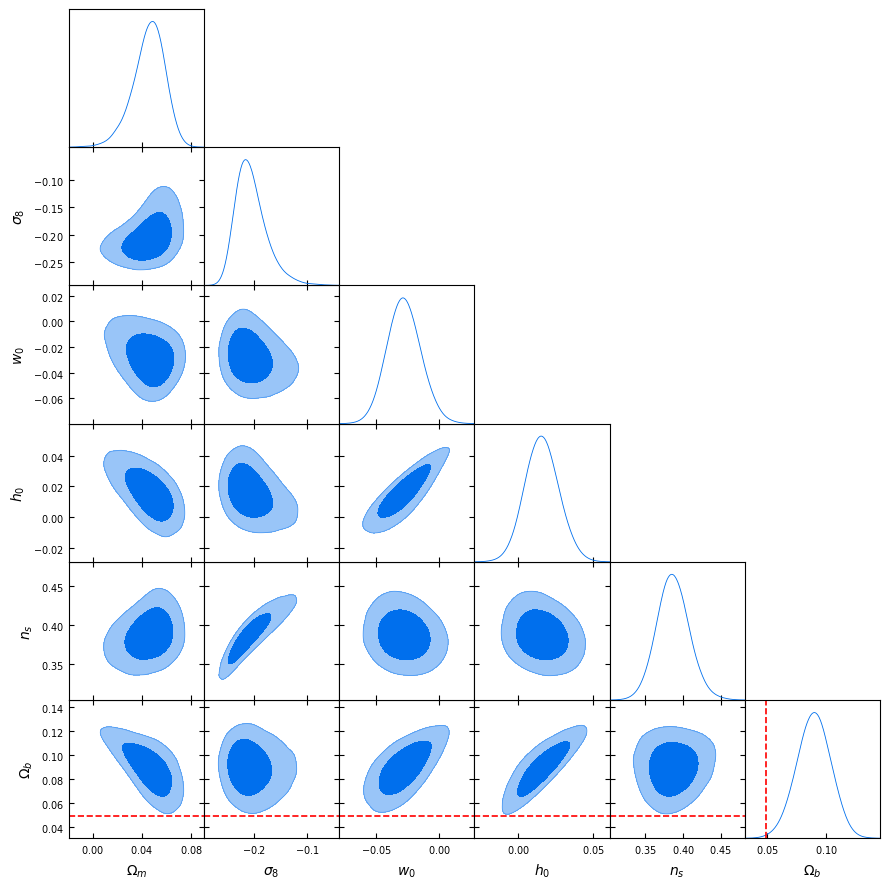

In [25]:
import getdist.plots as gplot
from getdist import MCSamples

%matplotlib inline

# Parameter names (for GetDist)
params_name = [r'\Omega_m', r'\sigma_8', r'w_0', r'h_0', r'n_s', r'\Omega_b']

# Convert samples (already in shape [num_samples, num_params])
sample_nd = np.array(sample_nd)  # Ensure it's a NumPy array

# Convert truth values to dictionary
truth_arr = np.array(truth)
theta_dict = dict(zip(params_name, truth_arr))

# Create MCSamples object for GetDist
samples = MCSamples(samples=sample_nd, names=params_name, labels=params_name)

# Create plotter
g = gplot.get_subplot_plotter(subplot_size=1.5)
g.triangle_plot(samples, filled=True, markers=truth_arr, marker_args={"color": "red", "lw": 1.2})

# Show plot
g.fig.show()

Removed no burn in


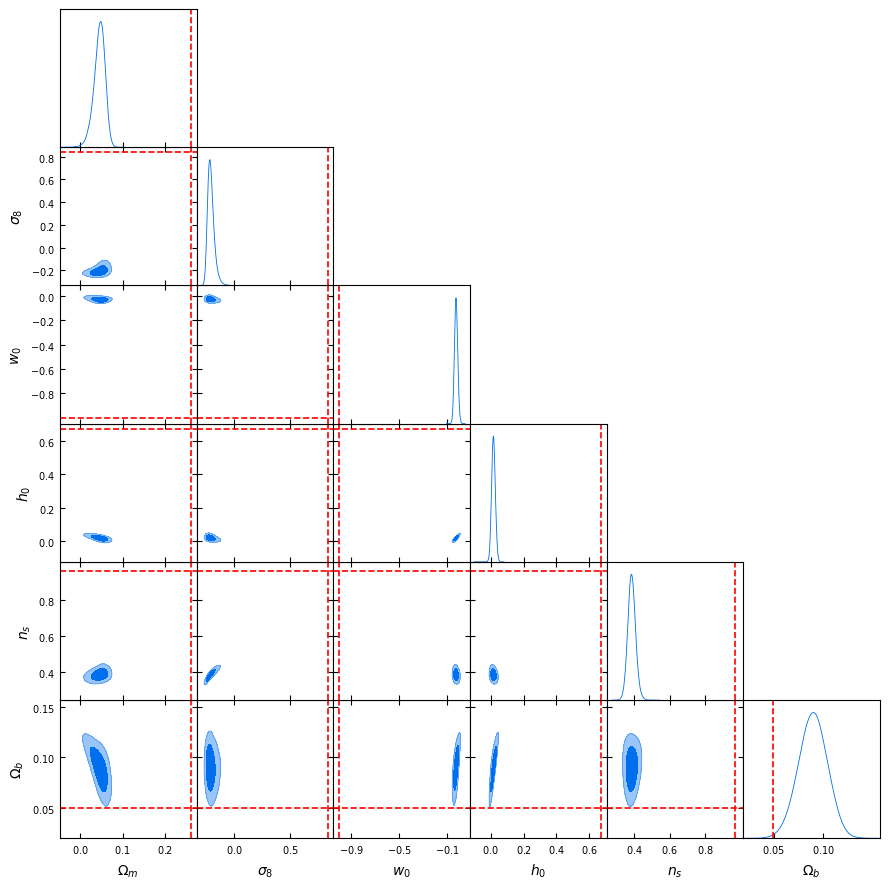

In [26]:
# Parameter names (for GetDist)
params_name = [r'\Omega_m', r'\sigma_8', r'w_0', r'h_0', r'n_s', r'\Omega_b']

# Convert samples (already in shape [num_samples, num_params])
sample_nd = np.array(sample_nd)  # Ensure it's a NumPy array

param_limits = {}
for i, name in enumerate(params_name):
    s_min, s_max = sample_nd[:, i].min(), sample_nd[:, i].max()
    truth_val = truth[i]

    lower = min(s_min, truth_val) - 0.05 * abs(truth_val)
    upper = max(s_max, truth_val) + 0.05 * abs(truth_val)
    
    param_limits[name] = (lower, upper)

# Convert truth values to dictionary
truth_arr = np.array(truth)
theta_dict = dict(zip(params_name, truth_arr))

# Create MCSamples object for GetDist
samples = MCSamples(samples=sample_nd, names=params_name, labels=params_name)

# Create plotter
g = gplot.get_subplot_plotter(subplot_size=1.5)
g.triangle_plot(samples, filled=True, markers=truth_arr, marker_args={"color": "red", "lw": 1.2}, param_limits=param_limits)

# Show plot
g.fig.show()

Defines functions for MCMC sampling: `log_prob_prior` (uniform priors), `log_prob_fn` (NDE-based log-likelihood), and `unnormalized_log_prob` (log-posterior).

In [30]:
print("######## DEFINING FUN FOR MCMC ########") 
# define prior 
def log_prob_prior(theta):
    Om_logprob = tfd.Uniform(0.1,0.5).log_prob(theta[0])
    s8_logprob = tfd.Uniform(0.4,1.4).log_prob(theta[1])
    h_logprob = tfd.Uniform(0.64, 0.82).log_prob(theta[3])
    Ob_logprob = tfd.Uniform(0.03,0.06).log_prob(theta[5])
    ns_logprob = tfd.Uniform(0.87, 1.07).log_prob(theta[4])
    w0_logprob = tfd.Uniform(-2.0, -0.333).log_prob(theta[2])
    return Om_logprob + s8_logprob + h_logprob + Ob_logprob + ns_logprob + w0_logprob
                                        

def log_prob_fn(params, theta, y):
        return nf_logp_ff.apply(params, theta, y)
    
@jax.vmap
def unnormalized_log_prob(theta):
    prior = log_prob_prior(theta)

    likelihood = log_prob_fn(
        params_ff,
        theta.reshape([1, 6]),
        jnp.array(compressed_m_data).reshape([1, 12]),
    )

    return likelihood + prior

######## DEFINING FUN FOR MCMC ########


Runs Hamiltonian Monte Carlo (HMC) using `tensorflow_probability.mcmc` to draw samples from the posterior distribution defined by the NDE and prior.

In [31]:
print("######## RUN MCMC ########") 
num_results = 100_000 
num_burnin_steps = 35_000
num_chains = 100
key = jax.random.PRNGKey(0)

# Initialize the HMC transition kernel.
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=1e-2,
    ),
    num_adaptation_steps=int(num_burnin_steps * 0.8),
)

# Run the chain (with burn-in).
# @jax.jit
def run_chain():
    # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=jnp.array(truth) * jnp.ones([num_chains, 6]),
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
        seed=key,
    )

    return samples, is_accepted

samples_hmc, is_accepted_hmc = run_chain()
sample_nd = samples_hmc[is_accepted_hmc]

######## RUN MCMC ########


Plots MCMC trace plots for each parameter for a subset of chains to visually assess convergence and mixing of the HMC sampler.

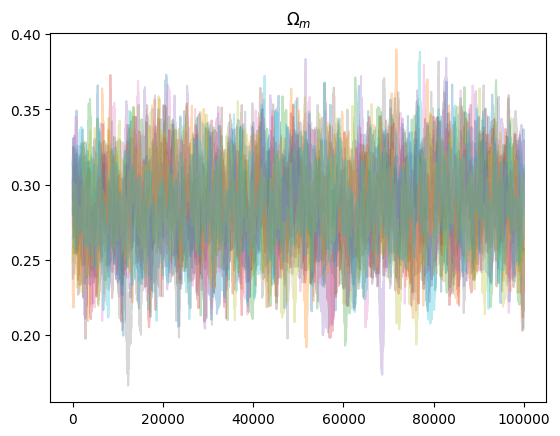

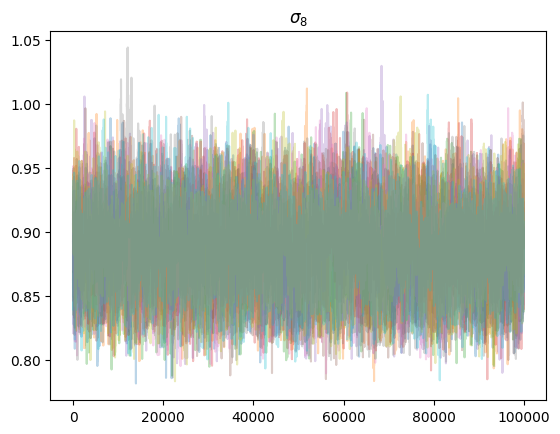

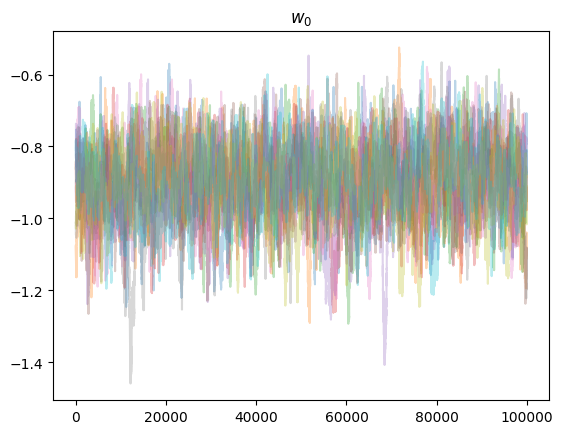

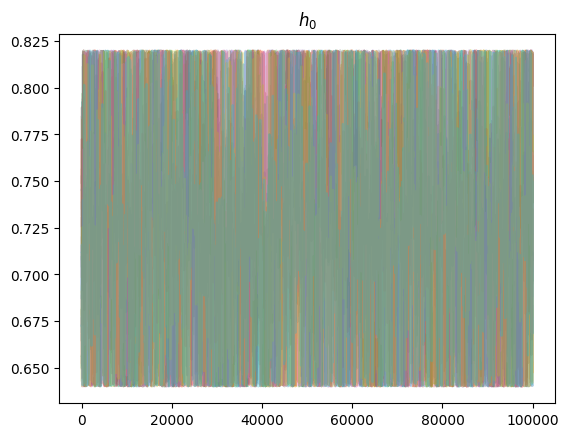

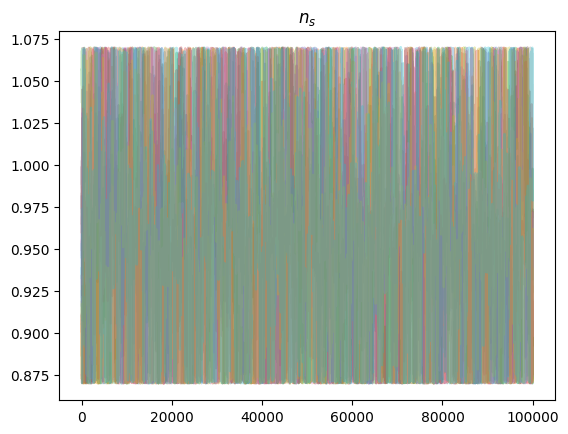

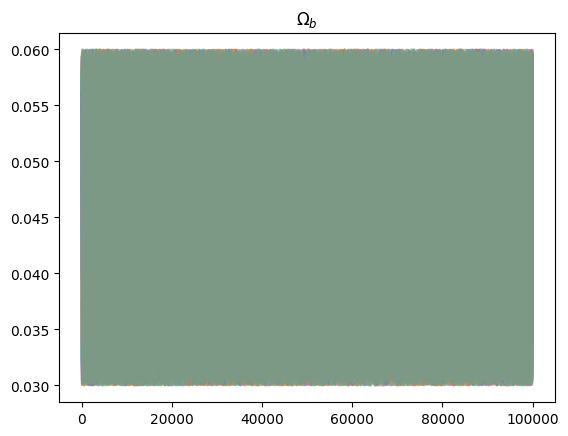

In [32]:
params_name = [r'$\Omega_m$',r'$\sigma_8$',r'$w_0$',r'$h_0$',r'$n_s$', r'$\Omega_b$']
for i in range(6):
    for j in range(10):
        plt.plot(samples_hmc[:,j, i], alpha=0.3)
        plt.title(params_name[i])
    plt.show()

Generates random samples from the defined prior distributions for each cosmological parameter, for comparison or plot extents.

In [33]:
Om_sample = tfd.Uniform(0.1,0.5).sample(1000, jax.random.PRNGKey(0))
s8_sample  = tfd.Uniform(0.4,1.4).sample(1000, jax.random.PRNGKey(10))
h_sample = tfd.Uniform(0.64, 0.82).sample(1000, jax.random.PRNGKey(20))
Ob_sample  = tfd.Uniform(0.03,0.06).sample(1000, jax.random.PRNGKey(30))
ns_sample  = tfd.Uniform(0.87, 1.07).sample(1000, jax.random.PRNGKey(40))
w0_sample  = tfd.Uniform(-2.0, -0.333).sample(1000, jax.random.PRNGKey(50))

prior = jnp.array([Om_sample, s8_sample, w0_sample, h_sample, ns_sample, Ob_sample]).T

Creates a triangle plot of the HMC posterior samples using `ChainConsumer`, overlaying truth values and setting plot extents based on prior distributions.

Removed no burn in


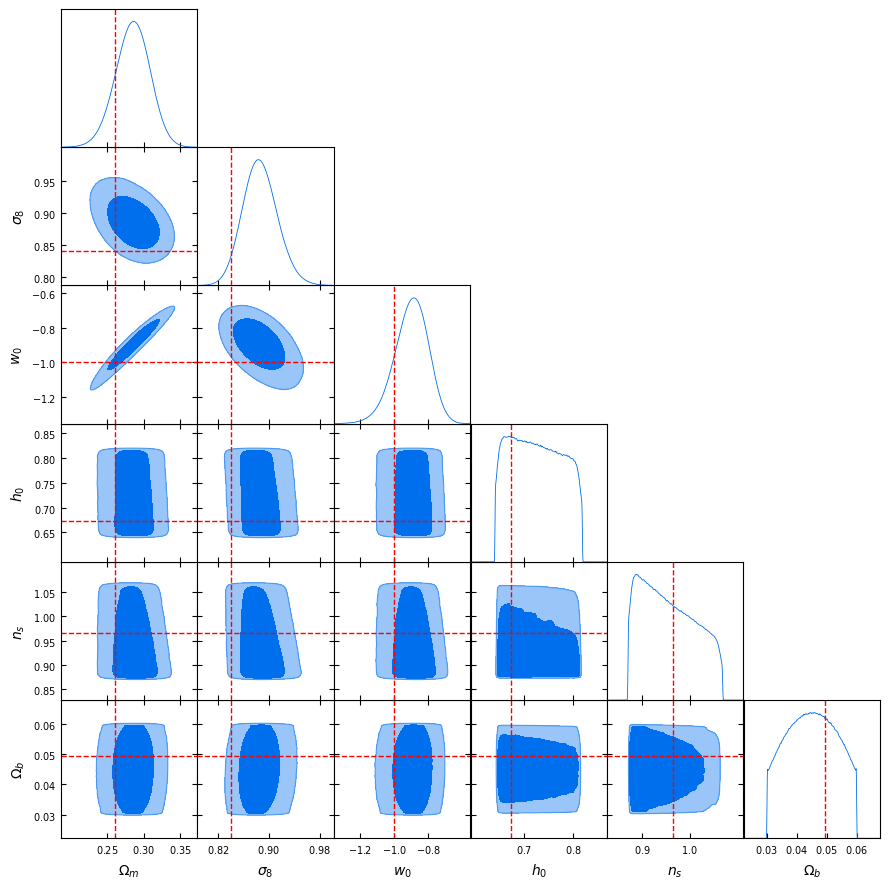

In [34]:
# Parameter names
params_name = [r'\Omega_m', r'\sigma_8', r'w_0', r'h_0', r'n_s', r'\Omega_b']

# Convert samples and truth values
sample_nd = np.array(sample_nd)  
truth_arr = np.array(truth)

# Create MCSamples object
samples = MCSamples(samples=sample_nd , names=params_name, labels=params_name)

# Create plotter
g = gplot.get_subplot_plotter(subplot_size=1.5)
g.settings.lw_contour = 2.0  # Thicker contours

# Triangle plot with markers
g.triangle_plot(samples, filled=True, markers=truth_arr, marker_args={"color": "red", "lw": 1.})

# Show plot
g.fig.show()


In [35]:
# save samples
jnp.save(f'posterior_{loss_name}_{map_kind}_gal_density{int(galaxy_density*4)}_tomographic_12features', samples.samples)

Removed no burn in


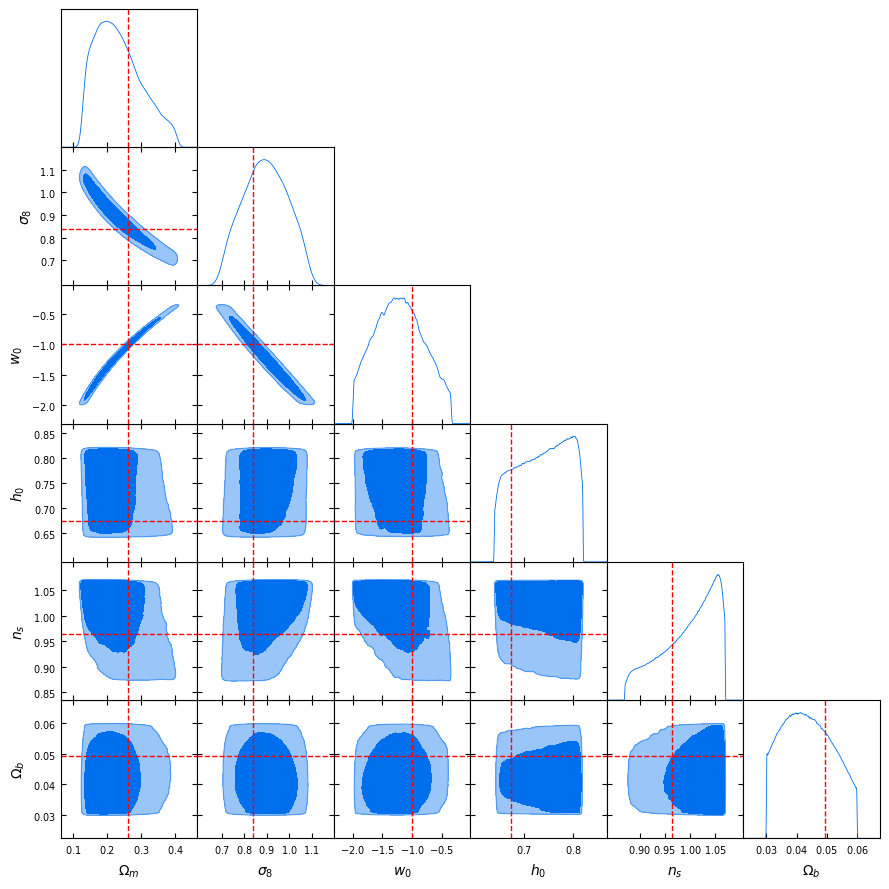

In [54]:
# Parameter names
params_name = [r'\Omega_m', r'\sigma_8', r'w_0', r'h_0', r'n_s', r'\Omega_b']

# Convert samples and truth values
sample_nd = np.array(sample_nd)  
truth_arr = np.array(truth)

# Create MCSamples object
samples = MCSamples(samples=sample_nd , names=params_name, labels=params_name)

# Create plotter
g = gplot.get_subplot_plotter(subplot_size=1.5)
g.settings.lw_contour = 2.0  # Thicker contours

# Triangle plot with markers
g.triangle_plot(samples, filled=True, markers=truth_arr, marker_args={"color": "red", "lw": 1.})

# Show plot
g.fig.show()


Saves the current HMC posterior samples (`sample_nd`) to a NumPy data file (`.npy`).

In [31]:
jnp.save(f'posterior_{loss_name}_{map_kind}_gal_density{int(galaxy_density*4)}_overfit_compressor_model', samples.samples)

### NPE

Defines the Neural Density Estimator (NDE) architecture using a `ConditionalRealNVP` (normalizing flow) model from `sbi_lens` via Haiku, to approximate `p(theta | y)`.

In [16]:
print("######## CREATE NDE ########")
# Create neural density estimator (NDE) to approximate p(theta | y)

summary_stat_dim = 12
nb_params_to_infer = 6
batch_size = 128


# Affine bijection used in the RealNVP coupling
bijector_ff = partial(
  AffineCoupling,
  layers=[128] * 4,
  activation=jax.nn.silu
)

# Normalizing Flow with 4 RealNVP coupling layers
NF_ff = partial(
  ConditionalRealNVP,
  n_layers=4,
  bijector_fn=bijector_ff
)

class NF(hk.Module):
    def __call__(self, y):
        nvp = NF_ff(nb_params_to_infer)(y)
        return nvp

# log probability of the NDE
nf_logp_ff = hk.without_apply_rng(
    hk.transform(
        lambda theta,y : NF()(y).log_prob(theta).squeeze()
    )
)

######## CREATE NDE ########


Defines utility functions for NDE training: `loss_nll` (negative log-likelihood loss) and a JIT-compiled `update` step for optimization.

In [17]:
print("######## UTILS FUN ########")

# negative log likelihood
def loss_nll(params, mu, batch):
    return - jnp.mean(nf_logp_ff.apply(params, mu, batch))

@jax.jit
def update(params, opt_state, mu, batch):
    """Single SGD update step."""
    loss, grads  = jax.value_and_grad(loss_nll)(
        params,
        mu,
        batch,
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

######## UTILS FUN ########


Trains the NDE (normalizing flow) using the Adam optimizer with an exponential decay learning rate. Saves model parameters periodically and plots batch loss.

In [18]:
print("######## TRAINING ########")
# init nf params
params_ff = nf_logp_ff.init(
    jax.random.PRNGKey(42),
    0.5 * jnp.zeros([1, 6]),
    0.5 * jnp.zeros([1, 6])
)

total_steps = 50_000
nb_steps = total_steps - total_steps * 0.2

lr_scheduler = optax.exponential_decay(
        init_value=1e-3,
        transition_steps=nb_steps // 50,
        decay_rate=0.9,
        end_value=1e-6,
)

# define optimizer
optimizer = optax.adam(learning_rate=lr_scheduler)
opt_state_ff = optimizer.init(params_ff)


# training
from tqdm import tqdm

batch_size = 128
batch_loss = []
loss_train = []
loss_test=[]
pbar = tqdm(range(total_steps))

for batch in pbar:
    inds = np.random.randint(0, len(dataset['theta']), batch_size)

    l, params_ff, opt_state_ff = update(
      params_ff,
      opt_state_ff,
      dataset['theta'][inds],
      dataset['x'][inds],
    )
    batch_loss.append(l)
    pbar.set_description(f"loss {l:.3f}")
    
    
    if batch % 1_000 == 0:

        # save params
        with open(f"/home/tersenov/software/Learn2Map/scripts/sbi/save_params/{loss_name}/nbody/params_nd_flow_batch{batch}.pkl", "wb") as fp:
            pickle.dump(params_ff, fp)


        inds2 = np.random.randint(0, len(dataset_test["theta"]), batch_size)
        b_loss_test, _, _ = update(
          params_ff,
          opt_state_ff,
          dataset_test["theta"][inds2],
          dataset_test['x'][inds2],
        )
        

        loss_train.append(l)
        loss_test.append(b_loss_test)


plt.plot(batch_loss[100:])

######## TRAINING ########


  0%|          | 0/50000 [00:00<?, ?it/s]


ValueError: 'nf/conditional_real_nvp/b0/layer0/w' with retrieved shape (9, 128) does not match shape=[15, 128] dtype=dtype('float32')

Plots the training and validation (test set) loss curves over training epochs for the NDE.

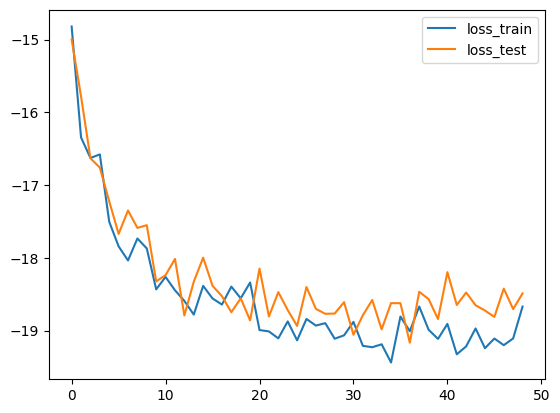

In [ ]:
plt.plot(loss_train[1:], label ='loss_train')
plt.plot(loss_test[1:], label = 'loss_test')
plt.legend()

Defines a list of LaTeX parameter names (`params_name`) and creates a dictionary `theta` mapping these names to their true fiducial cosmological values.

In [ ]:
params_name = [r'$\Omega_m$',r'$\sigma_8$',r'$w_0$',r'$h_0$',r'$n_s$', r'$\Omega_b$']
# make dictionary or {'name': value as float}
truth_arr = np.array(truth)
theta = dict(zip(params_name, truth_arr))

Samples from the trained NDE (likelihood) and visualizes the resulting distributions using `ChainConsumer`. Note: Conditioning in this cell might be for debugging/exploration.

In [ ]:
theta

{'$\\Omega_m$': 0.26,
 '$\\sigma_8$': 0.84,
 '$w_0$': -1.0,
 '$h_0$': 0.6736,
 '$n_s$': 0.9649,
 '$\\Omega_b$': 0.0493}

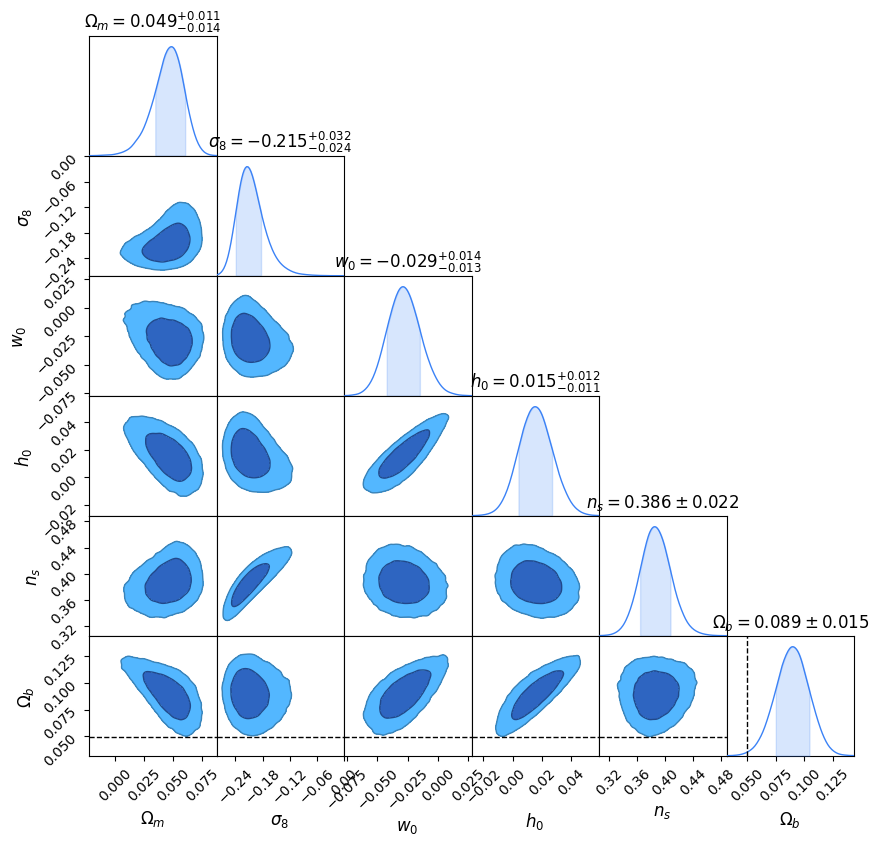

In [ ]:
# just checking the learned likelihood

nvp_sample_nd = hk.transform(
  lambda y : NF()(y).sample(100000, seed=hk.next_rng_key())
)

# plot infered params
sample_nd = nvp_sample_nd.apply(
      params_ff,
      rng = jax.random.PRNGKey(43),
      y = jnp.array(truth) * jnp.ones([100_000, 6])
)

params_name = [r'$\Omega_m$',r'$\sigma_8$',r'$w_0$',r'$h_0$',r'$n_s$', r'$\Omega_b$']
c = ChainConsumer()

import pandas as pd
from chainconsumer import Chain, ChainConsumer, Truth

df = pd.DataFrame(sample_nd, columns=params_name)  # Convert to DataFrame
chain = Chain(samples=df, name="SBI")  # Pass the DataFrame instead of NumPy array
c.add_chain(chain)
c.add_truth(Truth(location=theta))
# c.add_chain(
#     sample_nd,
#     shade_alpha = 0.5, 
#     parameters = params_name, 
#     name = f'sbi with {map_kind} maps'
# )

fig = c.plotter.plot(figsize=0.5)

Prints the individual true fiducial cosmological parameter values stored in `truth_arr`.

In [ ]:
for i, param in enumerate(params_name):
    # g.add_x_marker(truth_arr[i], color="red", linestyle="dashed")  # Vertical lines for truth
    print(truth_arr[i])

0.26
0.84
-1.0
0.6736
0.9649
0.0493


Generates a triangle plot of the samples obtained from the NDE using `getdist`, with true parameter values marked.

In [ ]:
truth_arr

array([ 0.26  ,  0.84  , -1.    ,  0.6736,  0.9649,  0.0493],
      dtype=float32)

Removed no burn in


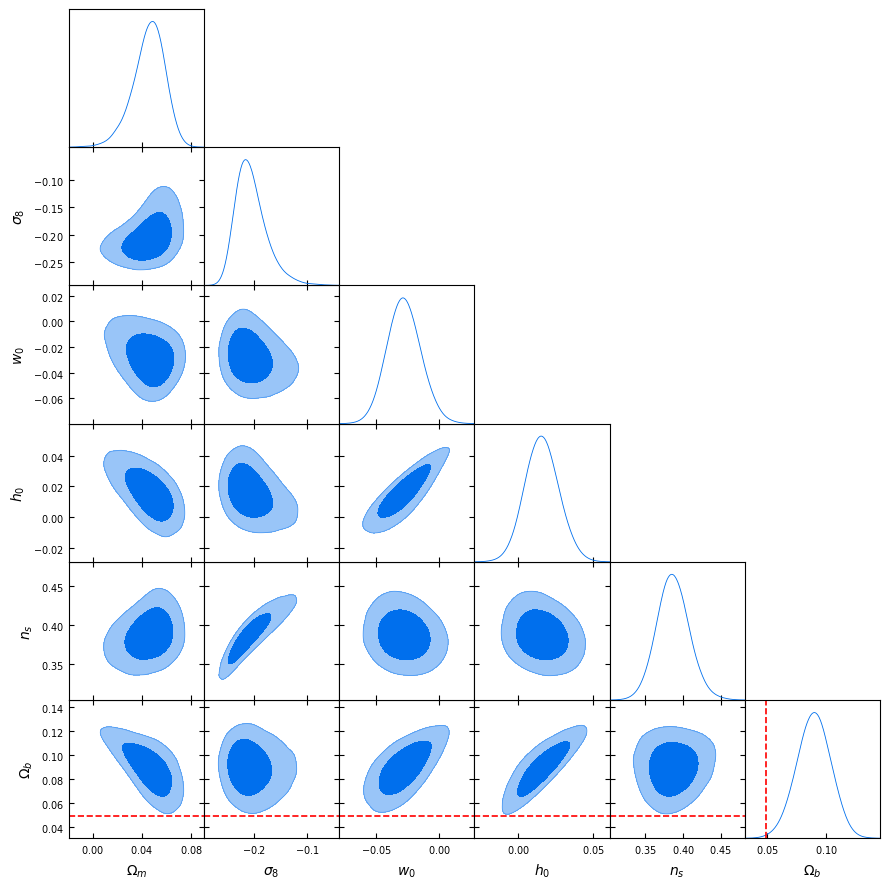

In [ ]:
import getdist.plots as gplot
from getdist import MCSamples

%matplotlib inline

# Parameter names (for GetDist)
params_name = [r'\Omega_m', r'\sigma_8', r'w_0', r'h_0', r'n_s', r'\Omega_b']

# Convert samples (already in shape [num_samples, num_params])
sample_nd = np.array(sample_nd)  # Ensure it's a NumPy array

# Convert truth values to dictionary
truth_arr = np.array(truth)
theta_dict = dict(zip(params_name, truth_arr))

# Create MCSamples object for GetDist
samples = MCSamples(samples=sample_nd, names=params_name, labels=params_name)

# Create plotter
g = gplot.get_subplot_plotter(subplot_size=1.5)
g.triangle_plot(samples, filled=True, markers=truth_arr, marker_args={"color": "red", "lw": 1.2})

# Show plot
g.fig.show()

Removed no burn in


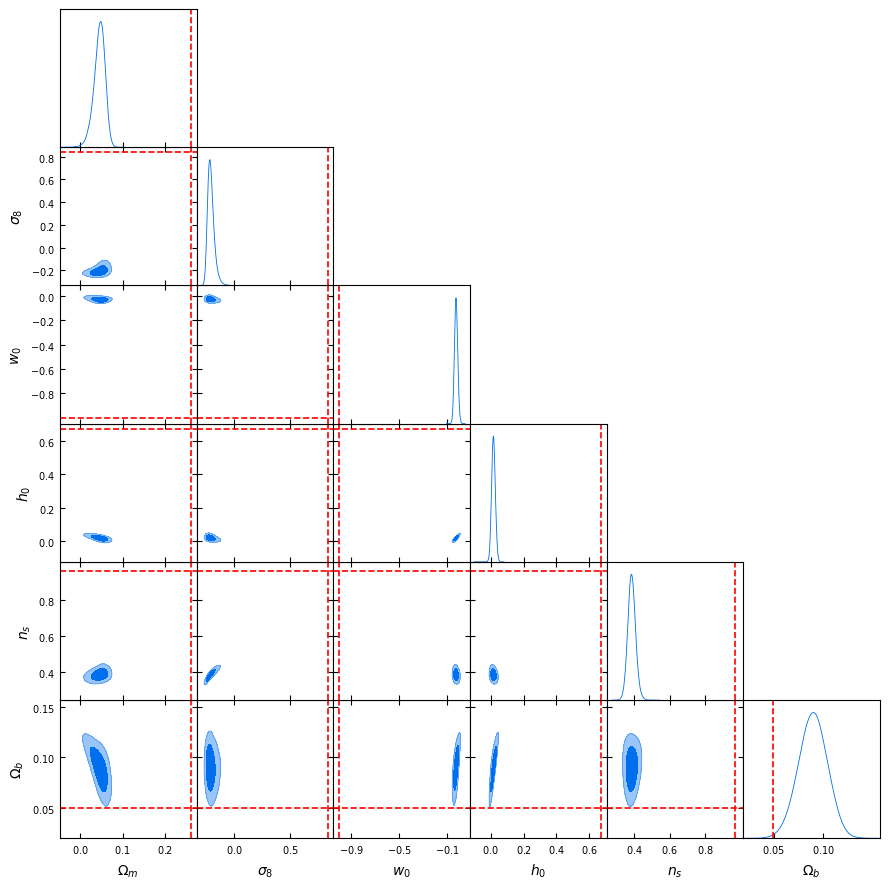

In [ ]:
# Parameter names (for GetDist)
params_name = [r'\Omega_m', r'\sigma_8', r'w_0', r'h_0', r'n_s', r'\Omega_b']

# Convert samples (already in shape [num_samples, num_params])
sample_nd = np.array(sample_nd)  # Ensure it's a NumPy array

param_limits = {}
for i, name in enumerate(params_name):
    s_min, s_max = sample_nd[:, i].min(), sample_nd[:, i].max()
    truth_val = truth[i]

    lower = min(s_min, truth_val) - 0.05 * abs(truth_val)
    upper = max(s_max, truth_val) + 0.05 * abs(truth_val)
    
    param_limits[name] = (lower, upper)

# Convert truth values to dictionary
truth_arr = np.array(truth)
theta_dict = dict(zip(params_name, truth_arr))

# Create MCSamples object for GetDist
samples = MCSamples(samples=sample_nd, names=params_name, labels=params_name)

# Create plotter
g = gplot.get_subplot_plotter(subplot_size=1.5)
g.triangle_plot(samples, filled=True, markers=truth_arr, marker_args={"color": "red", "lw": 1.2}, param_limits=param_limits)

# Show plot
g.fig.show()

Defines functions for MCMC sampling: `log_prob_prior` (uniform priors), `log_prob_fn` (NDE-based log-likelihood), and `unnormalized_log_prob` (log-posterior).

In [ ]:
print("######## DEFINING FUN FOR MCMC ########") 
# define prior 
def log_prob_prior(theta):
    Om_logprob = tfd.Uniform(0.1,0.5).log_prob(theta[0])
    s8_logprob = tfd.Uniform(0.4,1.4).log_prob(theta[1])
    h_logprob = tfd.Uniform(0.64, 0.82).log_prob(theta[3])
    Ob_logprob = tfd.Uniform(0.03,0.06).log_prob(theta[5])
    ns_logprob = tfd.Uniform(0.87, 1.07).log_prob(theta[4])
    w0_logprob = tfd.Uniform(-2.0, -0.333).log_prob(theta[2])
    return Om_logprob + s8_logprob + h_logprob + Ob_logprob + ns_logprob + w0_logprob
                                        

def log_prob_fn(params, theta, y):
        return nf_logp_ff.apply(params, theta, y)
    
@jax.vmap
def unnormalized_log_prob(theta):
    prior = log_prob_prior(theta)

    likelihood = log_prob_fn(
        params_ff,
        theta.reshape([1, 6]),
        jnp.array(compressed_m_data).reshape([1, 12]),
    )

    return likelihood + prior

######## DEFINING FUN FOR MCMC ########


Runs Hamiltonian Monte Carlo (HMC) using `tensorflow_probability.mcmc` to draw samples from the posterior distribution defined by the NDE and prior.

In [ ]:
print("######## RUN MCMC ########") 
num_results = 100_000 
num_burnin_steps = 35_000
num_chains = 100
key = jax.random.PRNGKey(0)

# Initialize the HMC transition kernel.
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=1e-2,
    ),
    num_adaptation_steps=int(num_burnin_steps * 0.8),
)

# Run the chain (with burn-in).
# @jax.jit
def run_chain():
    # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=jnp.array(truth) * jnp.ones([num_chains, 6]),
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
        seed=key,
    )

    return samples, is_accepted

samples_hmc, is_accepted_hmc = run_chain()
sample_nd = samples_hmc[is_accepted_hmc]

######## RUN MCMC ########


Plots MCMC trace plots for each parameter for a subset of chains to visually assess convergence and mixing of the HMC sampler.

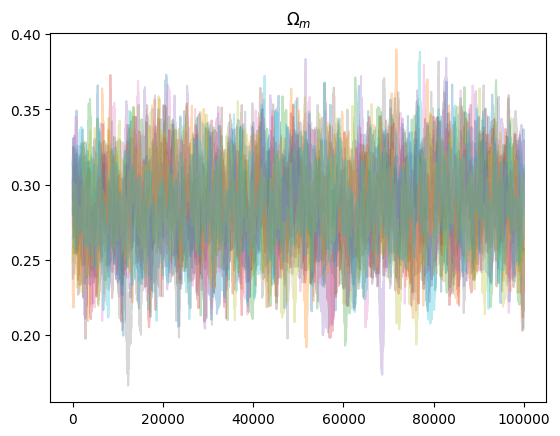

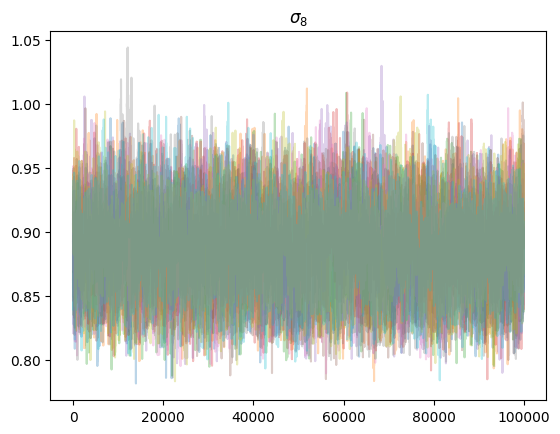

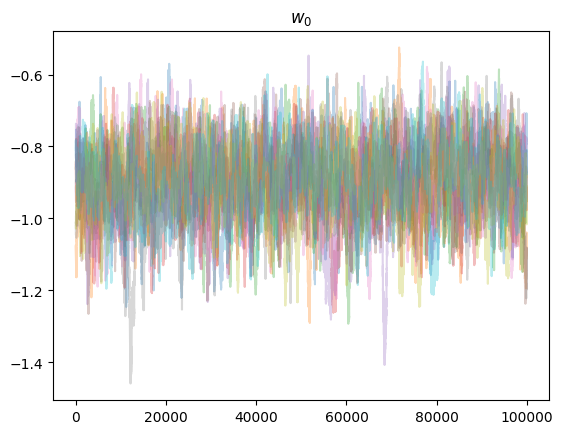

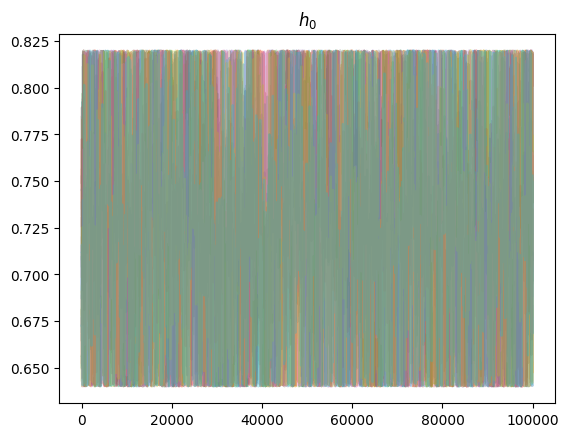

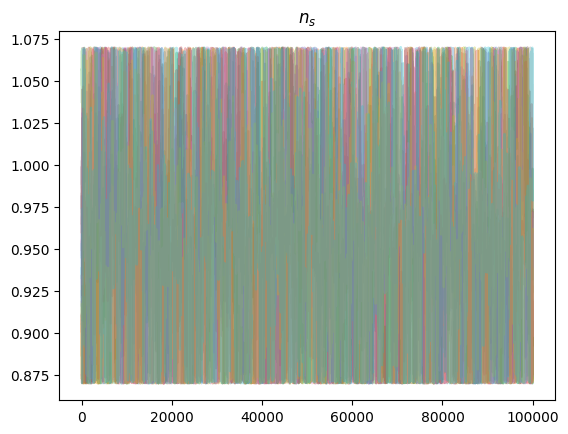

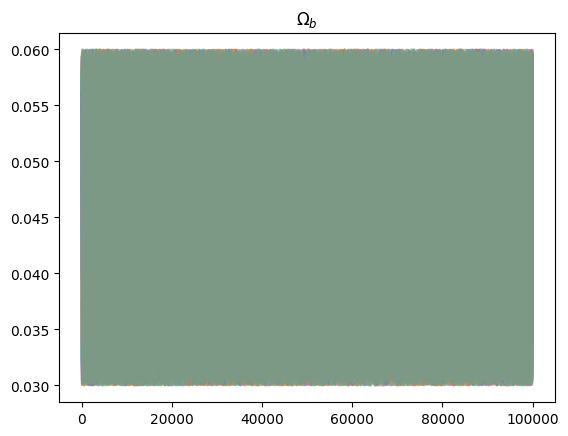

In [ ]:
params_name = [r'$\Omega_m$',r'$\sigma_8$',r'$w_0$',r'$h_0$',r'$n_s$', r'$\Omega_b$']
for i in range(6):
    for j in range(10):
        plt.plot(samples_hmc[:,j, i], alpha=0.3)
        plt.title(params_name[i])
    plt.show()

Generates random samples from the defined prior distributions for each cosmological parameter, for comparison or plot extents.

In [ ]:
Om_sample = tfd.Uniform(0.1,0.5).sample(1000, jax.random.PRNGKey(0))
s8_sample  = tfd.Uniform(0.4,1.4).sample(1000, jax.random.PRNGKey(10))
h_sample = tfd.Uniform(0.64, 0.82).sample(1000, jax.random.PRNGKey(20))
Ob_sample  = tfd.Uniform(0.03,0.06).sample(1000, jax.random.PRNGKey(30))
ns_sample  = tfd.Uniform(0.87, 1.07).sample(1000, jax.random.PRNGKey(40))
w0_sample  = tfd.Uniform(-2.0, -0.333).sample(1000, jax.random.PRNGKey(50))

prior = jnp.array([Om_sample, s8_sample, w0_sample, h_sample, ns_sample, Ob_sample]).T

Creates a triangle plot of the HMC posterior samples using `ChainConsumer`, overlaying truth values and setting plot extents based on prior distributions.

Removed no burn in


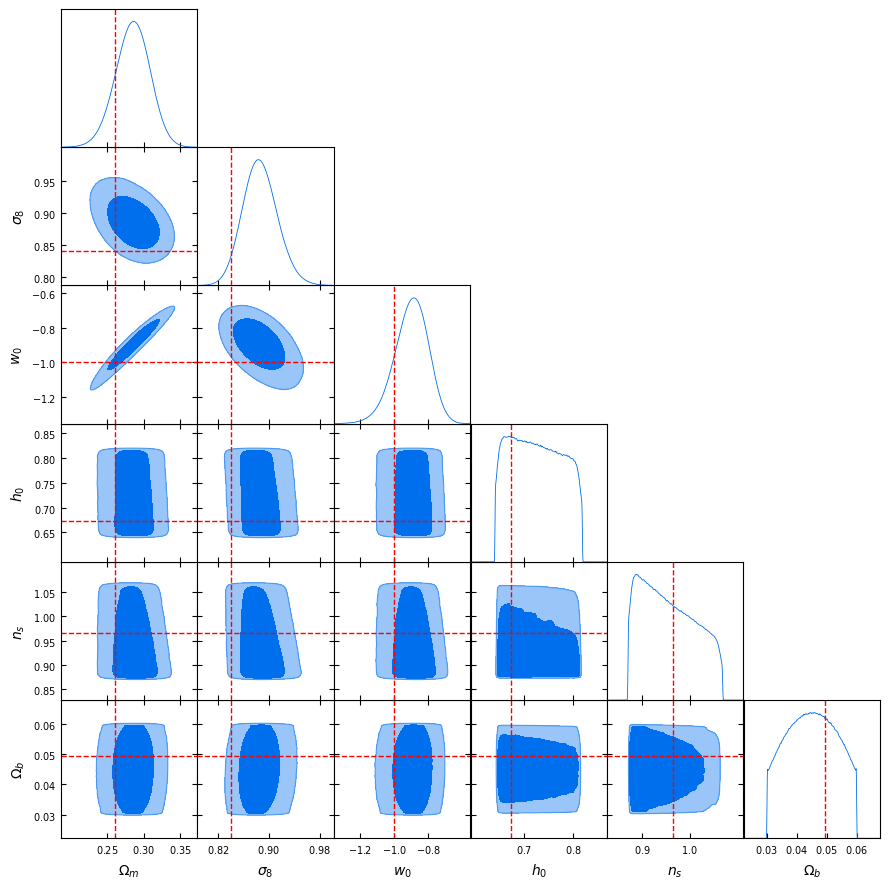

In [ ]:
# Parameter names
params_name = [r'\Omega_m', r'\sigma_8', r'w_0', r'h_0', r'n_s', r'\Omega_b']

# Convert samples and truth values
sample_nd = np.array(sample_nd)  
truth_arr = np.array(truth)

# Create MCSamples object
samples = MCSamples(samples=sample_nd , names=params_name, labels=params_name)

# Create plotter
g = gplot.get_subplot_plotter(subplot_size=1.5)
g.settings.lw_contour = 2.0  # Thicker contours

# Triangle plot with markers
g.triangle_plot(samples, filled=True, markers=truth_arr, marker_args={"color": "red", "lw": 1.})

# Show plot
g.fig.show()


In [ ]:
# save samples
jnp.save(f'posterior_{loss_name}_{map_kind}_gal_density{int(galaxy_density*4)}_tomographic_12features', samples.samples)

Removed no burn in


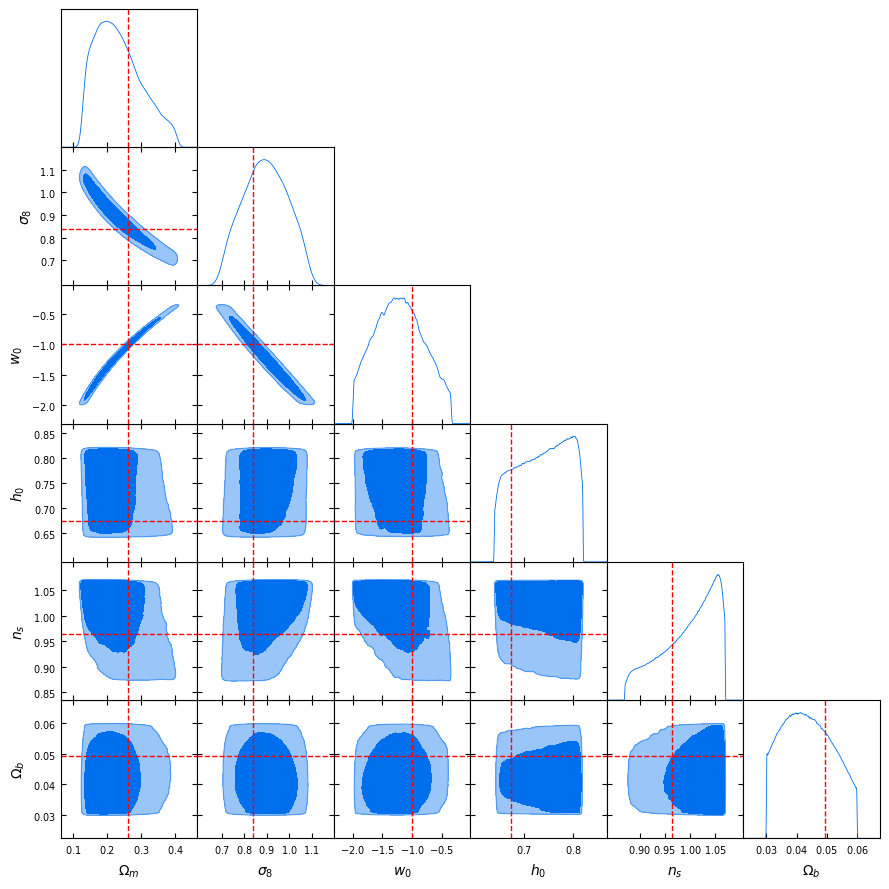

In [ ]:
# Parameter names
params_name = [r'\Omega_m', r'\sigma_8', r'w_0', r'h_0', r'n_s', r'\Omega_b']

# Convert samples and truth values
sample_nd = np.array(sample_nd)  
truth_arr = np.array(truth)

# Create MCSamples object
samples = MCSamples(samples=sample_nd , names=params_name, labels=params_name)

# Create plotter
g = gplot.get_subplot_plotter(subplot_size=1.5)
g.settings.lw_contour = 2.0  # Thicker contours

# Triangle plot with markers
g.triangle_plot(samples, filled=True, markers=truth_arr, marker_args={"color": "red", "lw": 1.})

# Show plot
g.fig.show()


Saves the current HMC posterior samples (`sample_nd`) to a NumPy data file (`.npy`).

In [ ]:
jnp.save(f'posterior_{loss_name}_{map_kind}_gal_density{int(galaxy_density*4)}_overfit_compressor_model', samples.samples)